## Ingeniería de features

Se añaden las siguientes variables:
- Estadísticos temporales de las acciones
- log(importe)
- Embeddings secuenciales calculados mediante el Encoder

### Carga de librerías y configuración

In [28]:
# Importación de librerías
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from ast import literal_eval
import torch
import pickle
from sklearn.model_selection import train_test_split
from ast import literal_eval
from imblearn.over_sampling import SMOTE

sys.path.append("..")
from app.utils.torch_utils import set_seed, CPU_Unpickler
from app.src.ActionTransformer import train_encoder, extract_seq_features
import app.src.ActionTransformer as at
sys.modules['ActionTransformer'] = at


plt.rcParams["figure.figsize"] = (8,4)

# Carpeta para guardar figuras
REPORTS_DIR = Path("../informes/figuras")
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

### Carga de dataset original y preprocesamiento

In [29]:
df = pd.read_pickle("../data/orig/FraudNLP_dataset.pkl")
action_vocab = pd.read_csv("../data/orig/vocab.csv")

# Sanity check
broken_times = df[df.times.apply(lambda x: x[-1]!="]")]
assert broken_times.shape[0] == 1
assert broken_times.iloc[0].is_fraud==0

# Ignorar la fila corrupta
df = df[df.times.apply(lambda x: x[-1]=="]")]

# Preprocesamiento de las acciones
action_names = action_vocab.Name.to_list()
id_to_action = {str(i):a for i,a in enumerate(action_names)}
action_to_id = {a:str(i) for i,a in enumerate(action_names)}

# Generación de nuevas features
df.actions = df.actions.apply(literal_eval)
df["times"] = df.times.apply(literal_eval).apply(lambda x: [i/1000 for i in x])
df["Action time mean"] = df.times.apply(np.mean)
df["Action time std"] = df.times.apply(np.std)
df["Action time median"] = df.times.apply(np.median)
df['n_actions'] = df['actions'].apply(len)
df["log(amount)"] = df.Amount.apply(np.log)
df["Transaction Type"] = df.is_fraud.apply(lambda x: "Fraud" if x else "Non Fraud")
df["time_to_first_action"] = df.times.apply(lambda x: x[1] if len(x)>1 else 0)
df["actions_str"] = df.actions.apply(lambda x: " ".join([id_to_action[str(i[0])] for i in x if len(i)>0]))
df["total_time_to_transaction"] = df.times.apply(sum)/1000
df['actions'] = df['actions'].apply(lambda x: [item for sublist in x for item in sublist])
df.head(2)

,actions,times,execution_time,Amount,device_freq,ip_freq,beneficiary_freq,application_freq,is_fraud,Action time mean,Action time std,Action time median,n_actions,log(amount),Transaction Type,time_to_first_action,actions_str,total_time_to_transaction
1,"[22, 27, 24, 1, 1268, 1269, 1267, 22, 29, 1, 2...","[0.0, 33.204, 215.636, 443.415, 72.586, 34.241...",203,13,1.0,1.000000,0.500000,1.0,0,177.859292,218.368580,46.2355,24,2.564949,Non Fraud,33.204,/PROFILE/GETCUSTOMERRESPONSE /TAXFREE/GETTAXGO...,4.268623
2,"[22, 24, 27, 1, 1268, 1269, 1267, 2, 23, 6, 25...","[0.0, 25.459, 46.236, 428.626, 42.785, 74.158,...",359,310,1.0,0.333333,0.333333,1.0,0,196.875569,252.496316,64.7660,2983,5.736572,Non Fraud,25.459,/PROFILE/GETCUSTOMERRESPONSE /CAMPAIGN/GETBALA...,587.279823


### 1) Exploración de nuevas variables

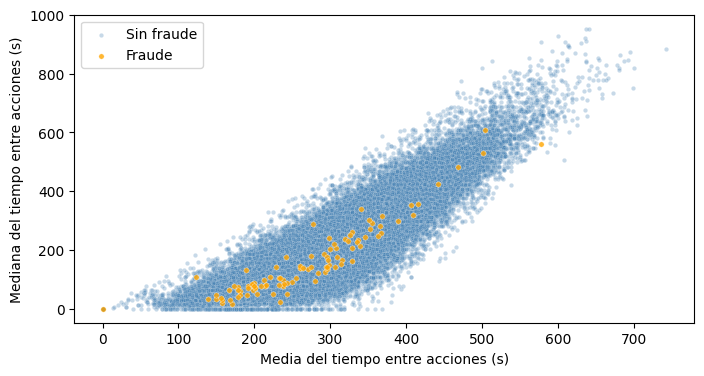

In [30]:
# primero non-fraud
sns.scatterplot(
    data=df[df["is_fraud"]==0],
    x="Action time mean", y="Action time median",
    color="steelblue", alpha=0.3, s=10, label="Sin fraude"
)

# luego fraud encima
sns.scatterplot(
    data=df[df["is_fraud"]==1],
    x="Action time mean", y="Action time median",
    color="orange", alpha=0.8, s=15, label="Fraude"
)

plt.xlabel("Media del tiempo entre acciones (s)")
plt.ylabel("Mediana del tiempo entre acciones (s)")
plt.legend()
plt.savefig(REPORTS_DIR/"action_mean_vs_action_median.png", bbox_inches="tight")
plt.show()

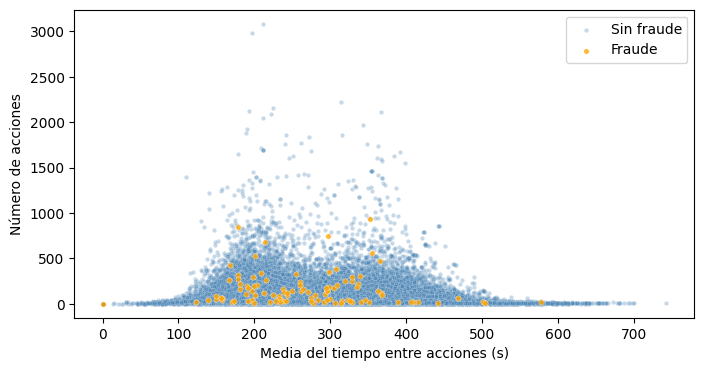

In [31]:
# primero non-fraud
sns.scatterplot(
    data=df[df["is_fraud"]==0],
    x="Action time mean", y="n_actions",
    color="steelblue", alpha=0.3, s=10, label="Sin fraude"
)

# luego fraud encima
sns.scatterplot(
    data=df[df["is_fraud"]==1],
    x="Action time mean", y="n_actions",
    color="orange", alpha=0.8, s=15, label="Fraude"
)

plt.xlabel("Media del tiempo entre acciones (s)")
plt.ylabel("Número de acciones")
plt.legend()
plt.savefig(REPORTS_DIR/"action_mean_vs_n_actions.png", bbox_inches="tight")
plt.show()

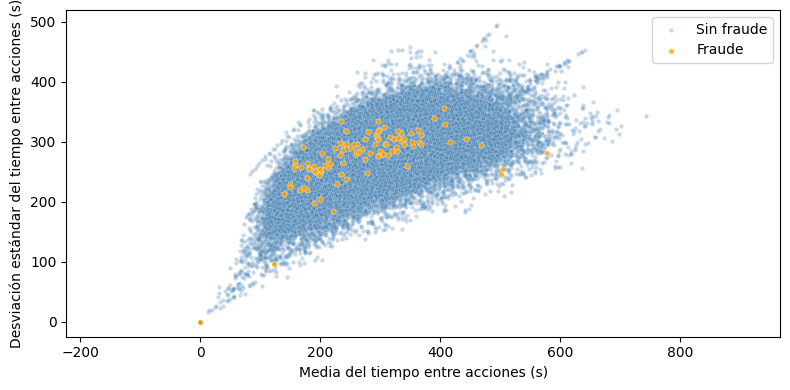

In [32]:
# primero non-fraud
sns.scatterplot(
    data=df[df["is_fraud"]==0],
    x="Action time mean", y="Action time std",
    color="steelblue", alpha=0.3, s=10, label="Sin fraude"
)

# luego fraud encima
sns.scatterplot(
    data=df[df["is_fraud"]==1],
    x="Action time mean", y="Action time std",
    color="orange", alpha=0.8, s=15, label="Fraude"
)

plt.xlabel("Media del tiempo entre acciones (s)")
plt.ylabel("Desviación estándar del tiempo entre acciones (s)")
plt.legend()
plt.tight_layout()
plt.axis('equal')
plt.savefig(REPORTS_DIR/"action_mean_vs_action_std.png", bbox_inches="tight")
plt.show()

### 2) Features mediante Transformer encoder

In [41]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
MAX_LEN = 256  # sequence length
RANDOM_STATE = 42

set_seed(RANDOM_STATE)

#### Preprocesamiento para el encoder

In [42]:
# Parsear las acciones
def parse_actions(x):
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        try:
            return literal_eval(x)
        except Exception:
            return []
    return []

df['actions'] = df['actions'].apply(parse_actions)
df['is_fraud'] = df['is_fraud'].astype(int)

#### Data split train/val/test

In [43]:
X = df.drop(columns=['is_fraud', 'log(amount)'])
y = df['is_fraud'].values
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.40, stratify=y, random_state=RANDOM_STATE
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.50, stratify=y_tmp, random_state=RANDOM_STATE
)
for name, yy in [('train', y_train), ('val', y_val), ('test', y_test)]:
    print(name, len(yy), f"pos={yy.sum()} ({yy.mean():.4%})")

train 63181 pos=61 (0.0965%)
val 21060 pos=20 (0.0950%)
test 21061 pos=20 (0.0950%)


#### Crear vocabulario de acciones y rellenar/truncar secuencias

In [44]:
def build_vocab(action_lists):
    """
    Construye un vocabulario (vocab) a partir de listas de acciones.
    """
    vocab = {0: '<PAD>'}  # 0 reservado para PAD
    next_id = 1
    for seq in action_lists:
        for a in seq:
            if a not in vocab:
                vocab[a] = str(a)   # asignamos el string de la acción como valor
                next_id += 1
    return vocab


def to_ids(seq, vocab, unk_id):
    """
    Convierte una secuencia de acciones en ids numéricos.
    """
    return [tok if tok in vocab else unk_id for tok in seq]


def pad_left(ids, max_len=256, pad_id=0):
    """
    Realiza padding a la izquierda para que todas las secuencias tengan la
    misma longitud (max_len).
    """
    ids = ids[-max_len:]                     # truncar si excede max_len
    pad = [pad_id] * (max_len - len(ids))    # rellenar con PAD a la izquierda
    return pad + ids


# ---------------------------------------------------
# Construcción del vocabulario y mapeo de secuencias
# ---------------------------------------------------

# Extraemos las secuencias de acciones desde dataframes de train, val y test
train_actions = X_train['actions'].tolist()
val_actions   = X_val['actions'].tolist()
test_actions  = X_test['actions'].tolist()

# Vocabulario a partir de acciones de entrenamiento
vocab = build_vocab(train_actions)

# Definimos el ID especial para UNK (un token desconocido que no está en vocab)
UNK_ID = max(vocab.keys()) + 1  # el siguiente entero tras el último id válido

# Número total de acciones (se usa para inicializar la capa embedding)
n_actions = UNK_ID  # ids válidos: 0..UNK_ID, el embedding tendrá +1 para UNK


def seqs_to_array(action_lists, vocab, unk_id, max_len=256):
    """
    Convierte una lista de secuencias de acciones en un array NumPy de IDs,
    aplicando to_ids y pad_left a cada secuencia.
    """
    arr = []
    for seq in action_lists:
        ids = to_ids(seq, vocab, unk_id)               # convertir a IDs
        arr.append(pad_left(ids, max_len=max_len))     # aplicar padding a la izquierda
    return np.array(arr, dtype=np.int64)


# Convertimos train/val/test en arrays listos para PyTorch
x_train_ids = seqs_to_array(train_actions, vocab, UNK_ID, MAX_LEN)
x_val_ids   = seqs_to_array(val_actions,   vocab, UNK_ID, MAX_LEN)
x_test_ids  = seqs_to_array(test_actions,  vocab, UNK_ID, MAX_LEN)

# Chequeo de dimensiones resultantes y tamaño del vocabulario
x_train_ids.shape, x_val_ids.shape, x_test_ids.shape, n_actions


((63181, 256), (21060, 256), (21061, 256), 1913)

In [45]:
# Aplicar SMOTE al conjunto de entrenamiento
smote = SMOTE(random_state=42)
x_train_ids_amp, y_train_amp = smote.fit_resample(x_train_ids, y_train)

#### Entrenar encoder

In [ ]:
if not os.path.exists('../app/modelos/encoder_results.pkl'):

    model = train_encoder(x_train_ids_amp, y_train_amp, x_val_ids, y_val, n_actions=n_actions, device=DEVICE, max_len=MAX_LEN,
                        epochs=10, bs=128, lr=2e-4)

    Z_train, p_seq_train = extract_seq_features(model, x_train_ids, DEVICE)
    Z_val,   p_seq_val   = extract_seq_features(model, x_val_ids, DEVICE)
    Z_test,  p_seq_test  = extract_seq_features(model, x_test_ids, DEVICE)
    
    data = {
        'model': model,
        'Z_train': Z_train,
        'p_seq_train': p_seq_train,
        'Z_val': Z_val,
        'p_seq_val': p_seq_val,
        'Z_test': Z_test,
        'p_seq_test': p_seq_test
    }

    # Guardar en pickle
    with open('../app/modelos/encoder_results.pkl', 'wb') as f:
        pickle.dump(data, f)

else:
    # Si ya se ha calculado utilizar el pickle
    cpu_map = lambda storage, loc: storage.cpu()
    with open('../app/modelos/encoder_results.pkl', 'rb') as f:
        data = CPU_Unpickler(f).load()

    model = data['model']
    Z_train = data['Z_train']
    p_seq_train = data['p_seq_train']
    Z_val = data['Z_val']
    p_seq_val = data['p_seq_val']
    Z_test = data['Z_test']
    p_seq_test = data['p_seq_test']

### 3) Correlaciones

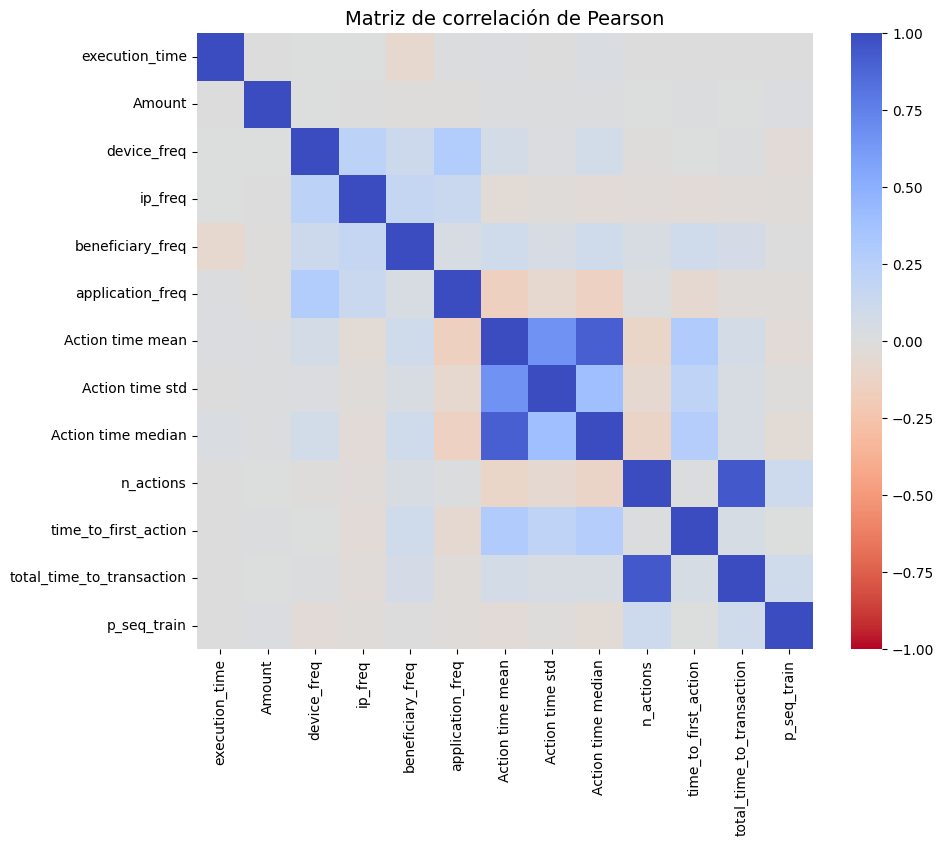

In [47]:
X_train = X_train.copy().drop(['actions','times','actions_str','Transaction Type'], axis=1)
X_train['p_seq_train'] = p_seq_train
corr = X_train.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    cmap="coolwarm_r",
    square=True,
    annot=False,
    vmin=-1, vmax=1,
    cbar=True,
    annot_kws={'size':20}
)

plt.title("Matriz de correlación de Pearson", fontsize=14)
plt.savefig(REPORTS_DIR/"matriz_correlacion.png", bbox_inches="tight")
plt.show()